In [1]:
from typing import Callable, Literal, Optional, Union
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.optimize import curve_fit

In [2]:
class DefaultPseudoLabeler:
    """Compute pseudo labels based on model predictions, typically from a teacher model.

    Args:
        activation: Activation function applied to the teacher prediction.
        confidence_threshold: Threshold for computing a mask for filtering the pseudo labels.
            If None is given no mask will be computed.
        threshold_from_both_sides: Whether to include both values bigger than the threshold
            and smaller than 1 - the thrhesold, or only values bigger than the threshold, in the mask.
            The former should be used for binary labels, the latter for for multiclass labels.
    """
    def __init__(
        self,
        activation: Optional[torch.nn.Module] = None,
        confidence_threshold: Optional[float] = None,
        threshold_from_both_sides: bool = True,
    ):
        self.activation = activation
        self.confidence_threshold = confidence_threshold
        self.threshold_from_both_sides = threshold_from_both_sides
        # TODO serialize the class names and kwargs for activation instead
        self.init_kwargs = {
            "activation": None, "confidence_threshold": confidence_threshold,
            "threshold_from_both_sides": threshold_from_both_sides
        }

    def _compute_label_mask_both_sides(self, pseudo_labels):
        upper_threshold = self.confidence_threshold
        lower_threshold = 1.0 - self.confidence_threshold
        mask = ((pseudo_labels >= upper_threshold) + (pseudo_labels <= lower_threshold)).to(dtype=torch.float32)
        return mask

    def _compute_label_mask_one_side(self, pseudo_labels):
        mask = (pseudo_labels >= self.confidence_threshold)
        return mask

    def __call__(self, teacher: torch.nn.Module, input_: torch.Tensor) -> torch.Tensor:
        """Compute pseudo-labels.

        Args:
            teacher: The teacher model.
            input_: The input for this batch.

        Returns:
            The pseudo-labels.
        """
        pseudo_labels = teacher(input_)
        if self.activation is not None:
            pseudo_labels = self.activation(pseudo_labels)
        if self.confidence_threshold is None:
            label_mask = None
        else:
            label_mask = self._compute_label_mask_both_sides(pseudo_labels) if self.threshold_from_both_sides\
                else self._compute_label_mask_one_side(pseudo_labels)
        return pseudo_labels, label_mask

    def step(self, metric, epoch):
        pass


In [12]:
"""import numpy as np
import torch
import torch.nn as nn
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max

def gaussian_3d(coords, amp, x0, y0, z0, sigma_x, sigma_y, sigma_z):
    x, y, z = coords
    return amp * np.exp(
        -(((x - x0)**2)/(2*sigma_x**2) + 
          ((y - y0)**2)/(2*sigma_y**2) + 
          ((z - z0)**2)/(2*sigma_z**2))
    ).ravel()

class DefaultPseudoLabeler:
    def __init__(self, confidence_threshold: float = 0.1):
        self.confidence_threshold = confidence_threshold

    def _fit_single_gaussian(self, data, peak_coord, patch_size=7):
        z, y, x = peak_coord
        half = patch_size // 2
        patch = data[
            max(z - half, 0):z + half + 1,
            max(y - half, 0):y + half + 1,
            max(x - half, 0):x + half + 1
        ]

        dz, dy, dx = patch.shape
        zz, yy, xx = np.mgrid[0:dz, 0:dy, 0:dx]
        coords = (xx, yy, zz)
        guess = (patch.max(), dx//2, dy//2, dz//2, 1, 1, 1)

        try:
            popt, _ = curve_fit(gaussian_3d, coords, patch.ravel(), p0=guess)
            amp, x0, y0, z0, sx, sy, sz = popt

            mask = (((xx - x0)**2)/(sx**2) + ((yy - y0)**2)/(sy**2) + ((zz - z0)**2)/(sz**2)) <= 1
            density_inside = patch[mask].sum()
            return density_inside
        except Exception:
            return 0.0

    def _compute_gaussian_density_mask(self, pseudo_labels):
        data = pseudo_labels.cpu().numpy()
        peaks = peak_local_max(data, min_distance=3, threshold_abs=0.1)
        densities = [self._fit_single_gaussian(data, tuple(p)) for p in peaks]
        mask = torch.tensor([d >= self.confidence_threshold for d in densities], dtype=torch.float32)
        return mask, peaks

    def __call__(self, teacher: nn.Module, input_: torch.Tensor):
        with torch.no_grad():
            pseudo_labels = teacher(input_).squeeze(0).squeeze(0)  # (1,1,D,H,W) → (D,H,W)
        mask, peaks = self._compute_gaussian_density_mask(pseudo_labels)
        return pseudo_labels, mask, peaks
"""

'import numpy as np\nimport torch\nimport torch.nn as nn\nfrom scipy.optimize import curve_fit\nfrom skimage.feature import peak_local_max\n\ndef gaussian_3d(coords, amp, x0, y0, z0, sigma_x, sigma_y, sigma_z):\n    x, y, z = coords\n    return amp * np.exp(\n        -(((x - x0)**2)/(2*sigma_x**2) + \n          ((y - y0)**2)/(2*sigma_y**2) + \n          ((z - z0)**2)/(2*sigma_z**2))\n    ).ravel()\n\nclass DefaultPseudoLabeler:\n    def __init__(self, confidence_threshold: float = 0.1):\n        self.confidence_threshold = confidence_threshold\n\n    def _fit_single_gaussian(self, data, peak_coord, patch_size=7):\n        z, y, x = peak_coord\n        half = patch_size // 2\n        patch = data[\n            max(z - half, 0):z + half + 1,\n            max(y - half, 0):y + half + 1,\n            max(x - half, 0):x + half + 1\n        ]\n\n        dz, dy, dx = patch.shape\n        zz, yy, xx = np.mgrid[0:dz, 0:dy, 0:dx]\n        coords = (xx, yy, zz)\n        guess = (patch.max(), dx//2

Input Map Shape: torch.Size([32, 32, 32])
Pseudo Labels Shape: torch.Size([32, 32, 32])


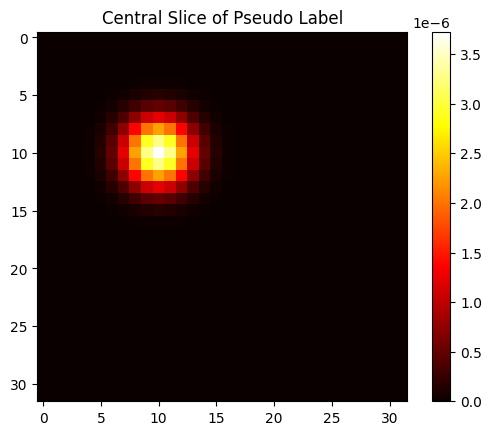

In [15]:
import matplotlib.pyplot as plt
import torch.nn as nn
class IdentityTeacher(nn.Module):
    def forward(self, x):
        return x

def create_synthetic_density_map(shape=(32,32,32), centers=[(16,16,16), (10,10,10)], sigma=2.0):
    data = np.zeros(shape, dtype=np.float32)
    zz, yy, xx = np.indices(shape)
    for z0, y0, x0 in centers:
        gauss = np.exp(-(((xx - x0)**2 + (yy - y0)**2 + (zz - z0)**2) / (2*sigma**2)))
        data += gauss
    return torch.tensor(data)  # (1,1,D,H,W)

# Run test
teacher = IdentityTeacher()
input_map = create_synthetic_density_map()
print("Input Map Shape:", input_map.shape)
labeler = DefaultPseudoLabeler(confidence_threshold=1.0)

pseudo_labels, mask, = labeler(teacher, input_map)
print("Pseudo Labels Shape:", pseudo_labels.shape)

# Show a central slice
plt.imshow(pseudo_labels[0].numpy(), cmap='hot')
plt.title('Central Slice of Pseudo Label')
plt.colorbar()
plt.show()


In [7]:
class DefaultPseudoLabeler_original:
    """Compute pseudo labels based on model predictions, typically from a teacher model.

    Args:
        activation: Activation function applied to the teacher prediction.
        confidence_threshold: Threshold for computing a mask for filtering the pseudo labels.
            If None is given no mask will be computed.
        threshold_from_both_sides: Whether to include both values bigger than the threshold
            and smaller than 1 - the thrhesold, or only values bigger than the threshold, in the mask.
            The former should be used for binary labels, the latter for for multiclass labels.
    """
    def __init__(
        self,
        activation: Optional[torch.nn.Module] = None,
        confidence_threshold: Optional[float] = None,
        threshold_from_both_sides: bool = True,
    ):
        self.activation = activation
        self.confidence_threshold = confidence_threshold
        self.threshold_from_both_sides = threshold_from_both_sides
        # TODO serialize the class names and kwargs for activation instead
        self.init_kwargs = {
            "activation": None, "confidence_threshold": confidence_threshold,
            "threshold_from_both_sides": threshold_from_both_sides
        }

    def _compute_label_mask_both_sides(self, pseudo_labels):
        upper_threshold = self.confidence_threshold
        lower_threshold = 1.0 - self.confidence_threshold
        mask = ((pseudo_labels >= upper_threshold) + (pseudo_labels <= lower_threshold)).to(dtype=torch.float32)
        return mask

    def _compute_label_mask_one_side(self, pseudo_labels):
        mask = (pseudo_labels >= self.confidence_threshold)
        return mask

    def __call__(self, teacher: torch.nn.Module, input_: torch.Tensor) -> torch.Tensor:
        """Compute pseudo-labels.

        Args:
            teacher: The teacher model.
            input_: The input for this batch.

        Returns:
            The pseudo-labels.
        """
        pseudo_labels = teacher(input_)
        if self.activation is not None:
            pseudo_labels = self.activation(pseudo_labels)
        if self.confidence_threshold is None:
            label_mask = None
        else:
            label_mask = self._compute_label_mask_both_sides(pseudo_labels) if self.threshold_from_both_sides\
                else self._compute_label_mask_one_side(pseudo_labels)
        return pseudo_labels, label_mask
    
    def visualize_masked_density_separate(self, pseudo_labels: torch.Tensor, label_mask: torch.Tensor, 
                       axis='z', n_slices=5):
        """Enhanced visualization showing:
        - Green: Confident particles (Gaussian fits)
        - Blue: Confident background
        - Gray: Uncertain regions
        """
        pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
        mask_np = label_mask.squeeze().detach().cpu().numpy().astype(bool)
        
        # Get background mask separately
        if self.threshold_from_both_sides:
            background_mask = (pseudo_np <= (1 - self.confidence_threshold))
        else:
            background_mask = np.zeros_like(pseudo_np, dtype=bool)
        
        D, H, W = pseudo_np.shape
        fig, axs = plt.subplots(3, n_slices, figsize=(15, 9))
        
        for i, idx in enumerate(np.linspace(0, D-1 if axis=='z' else H-1 if axis=='y' else W-1, n_slices, dtype=int)):
            # Get slices
            if axis == 'z':
                slc = pseudo_np[idx,:,:]
                mask_slc = mask_np[idx,:,:]
                bg_slc = background_mask[idx,:,:]
            elif axis == 'y':
                slc = pseudo_np[:,idx,:]
                mask_slc = mask_np[:,idx,:]
                bg_slc = background_mask[:,idx,:]
            else:
                slc = pseudo_np[:,:,idx]
                mask_slc = mask_np[:,:,idx]
                bg_slc = background_mask[:,:,idx]
            
            # Row 1: Raw density
            axs[0,i].imshow(slc, cmap='viridis')
            axs[0,i].set_title(f'Density {axis}={idx}')
            
            # Row 2: Particles (green) + Background (blue)
            axs[1,i].imshow(slc, cmap='gray')
            particles = np.ma.masked_where(~(mask_slc & ~bg_slc), np.ones_like(slc))
            background = np.ma.masked_where(~bg_slc, np.ones_like(slc))
            axs[1,i].imshow(particles, cmap='Greens', alpha=0.7)
            axs[1,i].imshow(background, cmap='Blues', alpha=0.3)
            axs[1,i].set_title('Confidence map')
            
            # Row 3: Intensity histogram
            axs[2,i].hist(slc.ravel(), bins=50, color='gray')
            axs[2,i].axvline(self.confidence_threshold, color='green', linestyle='--', label='Foreground thresh')
            if self.threshold_from_both_sides:
                axs[2,i].axvline(1-self.confidence_threshold, color='blue', linestyle='--', label='Background thresh')
            axs[2,i].legend()
        
        plt.tight_layout()
        plt.show()

    def visualize_masked_density(self, pseudo_labels: torch.Tensor, label_mask: torch.Tensor, 
                           axis='z', n_slices=5):
        """Clear visualization with proper green confidence regions"""
    
        # Convert tensors to numpy
        pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
        mask_np = label_mask.squeeze().detach().cpu().numpy()
        
        assert pseudo_np.shape == mask_np.shape, "Shape mismatch!"

        D, H, W = pseudo_np.shape
        
        # Get slice indices
        if axis == 'z':
            indices = np.linspace(0, D-1, n_slices, dtype=int)
        elif axis == 'y':
            indices = np.linspace(0, H-1, n_slices, dtype=int)
        elif axis == 'x':
            indices = np.linspace(0, W-1, n_slices, dtype=int)
        
        fig, axs = plt.subplots(2, n_slices, figsize=(15, 6))
        
        for i, idx in enumerate(indices):
            # Get slices
            if axis == 'z':
                density_slice = pseudo_np[idx, :, :]
                mask_slice = mask_np[idx, :, :]
            elif axis == 'y':
                density_slice = pseudo_np[:, idx, :]
                mask_slice = mask_np[:, idx, :]
            elif axis == 'x':
                density_slice = pseudo_np[:, :, idx]
                mask_slice = mask_np[:, :, idx]
            
            # Top: Density only
            im0 = axs[0,i].imshow(density_slice, cmap='viridis')
            axs[0,i].set_title(f'Density at {axis}={idx}')
            plt.colorbar(im0, ax=axs[0,i])
            
            # Bottom: Overlay - FIXED THE GREEN DISPLAY HERE
            axs[1,i].imshow(density_slice, cmap='gray')
            # Create proper green overlay (only where mask=1)
            overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
            im1 = axs[1,i].imshow(overlay, cmap='Greens', alpha=0.5, vmin=0, vmax=1)
            axs[1,i].set_title(f'Confidence at {axis}={idx}')
            
        plt.tight_layout()
        plt.show()
    def step(self, metric, epoch):
        pass


Loaded Pseudo Labels Shape: torch.Size([184, 630, 630])



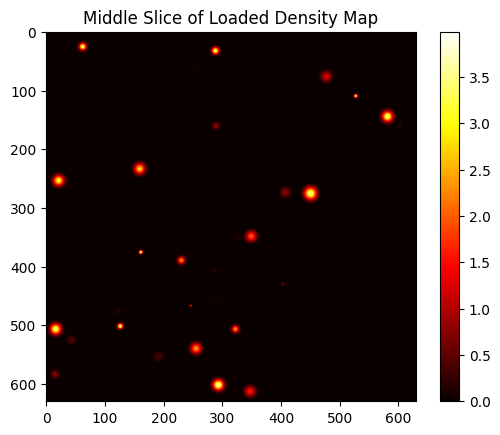

'# Output summary\nprint(f"Detected {len(peaks)} peaks.")\nprint("Filtered mask:", mask)\n'

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt


# --- Load density map from .npy file ---
def load_density_map_from_npy(file_path):
    data = np.load(file_path).astype(np.float32)
    if data.ndim != 3:
        raise ValueError("Expected a 3D density map.")
    return torch.tensor(data)  # Shape: (1, 1, D, H, W)

# --- Example usage ---
file_path = '/Users/yusufberkoruc/Desktop/Master_thesis/heat_map_output/0_heatmap.npy'  # Replace with your file path
input_map = load_density_map_from_npy(file_path)

teacher = IdentityTeacher()  # or your own model
labeler = DefaultPseudoLabeler(confidence_threshold=0.6,threshold_from_both_sides=True)

pseudo_labels, mask = labeler(teacher, input_map)
print("Loaded Pseudo Labels Shape:", pseudo_labels.shape)
# Visualize the loaded density map
print()
# Visualize a slice
middle_slice = pseudo_labels.shape[0] // 2
plt.imshow(pseudo_labels[middle_slice].numpy(), cmap='hot')
plt.title('Middle Slice of Loaded Density Map')
plt.colorbar()
plt.show()

"""# Output summary
print(f"Detected {len(peaks)} peaks.")
print("Filtered mask:", mask)
"""

In [ ]:
import matplotlib.pyplot as plt

class IdentityTeacher(nn.Module):
    def forward(self, x):
        return x

def load_density_map_from_npy(file_path):
    data = np.load(file_path).astype(np.float32)
    if data.ndim != 3:
        raise ValueError("Expected a 3D density map.")
    return torch.tensor(data).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, D, H, W)



input_map = load_density_map_from_npy(file_path)

"""# === Run labeler ===
teacher = IdentityTeacher()
labeler = DefaultPseudoLabeler(confidence_threshold=0.6, verbose=True)
pseudo_labels, mask, peaks = labeler(teacher, input_map)

# === Show a central slice ===
center_z = pseudo_labels.shape[0] // 2
plt.imshow(pseudo_labels[center_z].numpy(), cmap='hot')
plt.title(f'Central Slice (Z={center_z})')
plt.colorbar()
plt.show()

# === Optional: show a few detected peaks ===
for i, coord in enumerate(peaks[:5]):
    z, y, x = coord
    patch = pseudo_labels[z-3:z+4, y-3:y+4, x-3:x+4].numpy()
    if patch.shape[0] == 7:
        plt.imshow(patch[3], cmap='hot')  # middle z-slice
        plt.title(f"Peak {i} at {coord}")
        plt.colorbar()
        plt.show()"""


'# === Run labeler ===\nteacher = IdentityTeacher()\nlabeler = DefaultPseudoLabeler(confidence_threshold=0.6, verbose=True)\npseudo_labels, mask, peaks = labeler(teacher, input_map)\n\n# === Show a central slice ===\ncenter_z = pseudo_labels.shape[0] // 2\nplt.imshow(pseudo_labels[center_z].numpy(), cmap=\'hot\')\nplt.title(f\'Central Slice (Z={center_z})\')\nplt.colorbar()\nplt.show()\n\n# === Optional: show a few detected peaks ===\nfor i, coord in enumerate(peaks[:5]):\n    z, y, x = coord\n    patch = pseudo_labels[z-3:z+4, y-3:y+4, x-3:x+4].numpy()\n    if patch.shape[0] == 7:\n        plt.imshow(patch[3], cmap=\'hot\')  # middle z-slice\n        plt.title(f"Peak {i} at {coord}")\n        plt.colorbar()\n        plt.show()'

In [ ]:

def gaussian_3d(coords, A, x0, y0, z0, sx, sy, sz):
    x, y, z = coords
    return A * np.exp(-(((x - x0) ** 2) / (2 * sx ** 2) +
                        ((y - y0) ** 2) / (2 * sy ** 2) +
                        ((z - z0) ** 2) / (2 * sz ** 2))).ravel()


class GaussianPseudoLabeler:
    def __init__(
        self,
        activation: Optional[torch.nn.Module] = None,
        confidence_threshold: Optional[float] = None,
        threshold_from_both_sides: bool = True,
        patch_size: int = 9,
        peak_threshold_abs: float = 0.1,
        peak_min_distance: int = 3,
        min_density_inside: float = 0.2,
        min_amp: float = 0.05,
    ):
        self.activation = activation
        self.confidence_threshold = confidence_threshold
        self.threshold_from_both_sides = threshold_from_both_sides
        self.patch_size = patch_size
        self.peak_threshold_abs = peak_threshold_abs
        self.peak_min_distance = peak_min_distance
        self.min_density_inside = min_density_inside
        self.min_amp = min_amp
        self.init_kwargs = {
            "activation": None,
            "confidence_threshold": confidence_threshold,
            "threshold_from_both_sides": threshold_from_both_sides,
        }

    def _fit_single_gaussian(self, data, peak_coord):
        z, y, x = peak_coord
        half = self.patch_size // 2
        patch = data[
            max(z - half, 0):z + half + 1,
            max(y - half, 0):y + half + 1,
            max(x - half, 0):x + half + 1
        ]
        
        # Early rejection if patch is too small or flat
        if patch.max() - patch.min() < 0.1:  # Adjust threshold as needed
            return None

        zz, yy, xx = np.mgrid[0:patch.shape[0], 0:patch.shape[1], 0:patch.shape[2]]
        coords = (xx, yy, zz)
        
        # Improved initial guess
        guess = (
            patch.max(),  # Amplitude
            patch.shape[2] // 2,  # x center
            patch.shape[1] // 2,  # y center
            patch.shape[0] // 2,  # z center
            1.0,  # sx
            1.0,  # sy
            1.0   # sz
        )
        
        try:
            # Add bounds to prevent unrealistic fits
            bounds = (
                [0.1, 0, 0, 0, 0.5, 0.5, 0.5],  # Lower bounds
                [2.0, patch.shape[2], patch.shape[1], patch.shape[0], 
                3.0, 3.0, 3.0]  # Upper bounds
            )
            
            popt, pcov = curve_fit(gaussian_3d, coords, patch.ravel(), 
                                p0=guess, bounds=bounds, maxfev=1000)
            
            # Check covariance matrix quality
            if np.any(np.diag(pcov) > 1.0):  # Large variance indicates poor fit
                return None
                
            amp, x0, y0, z0, sx, sy, sz = popt
            
            if amp < self.min_amp or sx > 2.5 or sy > 2.5 or sz > 2.5:
                return None

            # Return global coordinates
            return (
                z + z0 - patch.shape[0] // 2,
                y + y0 - patch.shape[1] // 2,
                x + x0 - patch.shape[2] // 2,
                sz, sy, sx
            )
        except (RuntimeError, ValueError):
            return None

    def _compute_gaussian_mask(self, data: np.ndarray):
        shape = data.shape
        peaks = peak_local_max(
            data,
            min_distance=self.peak_min_distance,
            threshold_abs=self.peak_threshold_abs
        )

        mask = np.zeros(shape, dtype=bool)
        for p in peaks:
            result = self._fit_single_gaussian(data, tuple(p))
            if result is None:
                continue
            zc, yc, xc, sz, sy, sx = result
            Z, Y, X = np.indices(shape)
            ellipsoid = (((X - xc) ** 2) / (sx ** 2) +
                         ((Y - yc) ** 2) / (sy ** 2) +
                         ((Z - zc) ** 2) / (sz ** 2)) <= 1
            mask |= ellipsoid
        return torch.tensor(mask, dtype=torch.float32)

    def __call__(self, teacher: torch.nn.Module, input_: torch.Tensor) -> torch.Tensor:
        pseudo_labels = teacher(input_)
        if self.activation is not None:
            pseudo_labels = self.activation(pseudo_labels)

        if self.confidence_threshold is None:
            label_mask = None
        else:
            pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
            
            # 1. Get confident foreground via Gaussian fitting
            gaussian_mask = self._compute_gaussian_mask(pseudo_np)
            
            # 2. Get confident background via thresholding
            if self.threshold_from_both_sides:
                background_mask = (pseudo_np <= (1 - self.confidence_threshold))
            else:
                background_mask = np.zeros_like(pseudo_np, dtype=bool)
            
            # 3. Combine masks (convert to boolean first)
            confidence_mask = gaussian_mask.bool() | torch.from_numpy(background_mask)
            label_mask = confidence_mask.float().to(pseudo_labels.device)

        return pseudo_labels, label_mask

    def visualize_masked_density_separate(self, pseudo_labels: torch.Tensor, label_mask: torch.Tensor, 
                       axis='z', n_slices=5):
        """Enhanced visualization showing:
        - Green: Confident particles (Gaussian fits)
        - Blue: Confident background
        - Gray: Uncertain regions
        """
        pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
        mask_np = label_mask.squeeze().detach().cpu().numpy().astype(bool)
        
        # Get background mask separately
        if self.threshold_from_both_sides:
            background_mask = (pseudo_np <= (1 - self.confidence_threshold))
        else:
            background_mask = np.zeros_like(pseudo_np, dtype=bool)
        
        D, H, W = pseudo_np.shape
        fig, axs = plt.subplots(3, n_slices, figsize=(15, 9))
        
        for i, idx in enumerate(np.linspace(0, D-1 if axis=='z' else H-1 if axis=='y' else W-1, n_slices, dtype=int)):
            # Get slices
            if axis == 'z':
                slc = pseudo_np[idx,:,:]
                mask_slc = mask_np[idx,:,:]
                bg_slc = background_mask[idx,:,:]
            elif axis == 'y':
                slc = pseudo_np[:,idx,:]
                mask_slc = mask_np[:,idx,:]
                bg_slc = background_mask[:,idx,:]
            else:
                slc = pseudo_np[:,:,idx]
                mask_slc = mask_np[:,:,idx]
                bg_slc = background_mask[:,:,idx]
            
            # Row 1: Raw density
            axs[0,i].imshow(slc, cmap='viridis')
            axs[0,i].set_title(f'Density {axis}={idx}')
            
            # Row 2: Particles (green) + Background (blue)
            axs[1,i].imshow(slc, cmap='gray')
            particles = np.ma.masked_where(~(mask_slc & ~bg_slc), np.ones_like(slc))
            background = np.ma.masked_where(~bg_slc, np.ones_like(slc))
            axs[1,i].imshow(particles, cmap='Greens', alpha=0.7)
            axs[1,i].imshow(background, cmap='Blues', alpha=0.3)
            axs[1,i].set_title('Confidence map')
            
            # Row 3: Intensity histogram
            axs[2,i].hist(slc.ravel(), bins=50, color='gray')
            axs[2,i].axvline(self.confidence_threshold, color='green', linestyle='--', label='Foreground thresh')
            if self.threshold_from_both_sides:
                axs[2,i].axvline(1-self.confidence_threshold, color='blue', linestyle='--', label='Background thresh')
            axs[2,i].legend()
        
        plt.tight_layout()
        plt.show()

    def visualize_masked_density(self, pseudo_labels: torch.Tensor, label_mask: torch.Tensor, 
                        axis='z', n_slices=5):
        """Visualization with green showing all confident regions"""
        # Convert tensors to numpy and ensure proper types
        pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
        mask_np = label_mask.squeeze().detach().cpu().numpy().astype(bool)  # Convert to boolean
        
        D, H, W = pseudo_np.shape
        
        # Get slice indices
        if axis == 'z':
            indices = np.linspace(0, D-1, n_slices, dtype=int)
        elif axis == 'y':
            indices = np.linspace(0, H-1, n_slices, dtype=int)
        elif axis == 'x':
            indices = np.linspace(0, W-1, n_slices, dtype=int)
        
        fig, axs = plt.subplots(2, n_slices, figsize=(15, 6))
        
        for i, idx in enumerate(indices):
            # Get slices
            if axis == 'z':
                density_slice = pseudo_np[idx, :, :]
                mask_slice = mask_np[idx, :, :]
            elif axis == 'y':
                density_slice = pseudo_np[:, idx, :]
                mask_slice = mask_np[:, idx, :]
            elif axis == 'x':
                density_slice = pseudo_np[:, :, idx]
                mask_slice = mask_np[:, :, idx]
            
            # Top: Density only
            im0 = axs[0,i].imshow(density_slice, cmap='viridis')
            axs[0,i].set_title(f'Density at {axis}={idx}')
            plt.colorbar(im0, ax=axs[0,i])
            
            # Bottom: Confidence overlay
            axs[1,i].imshow(density_slice, cmap='gray')
            # Create proper green overlay (only where mask=True)
            overlay = np.ma.masked_where(~mask_slice, np.ones_like(mask_slice))  # Use ones_like for visualization
            im1 = axs[1,i].imshow(overlay, cmap='Greens', alpha=0.5, vmin=0, vmax=1)
            axs[1,i].set_title(f'Confidence at {axis}={idx}')
        
        plt.tight_layout()
        plt.show()
    def step(self, metric, epoch):
        pass


Visualizing along Z-axis:


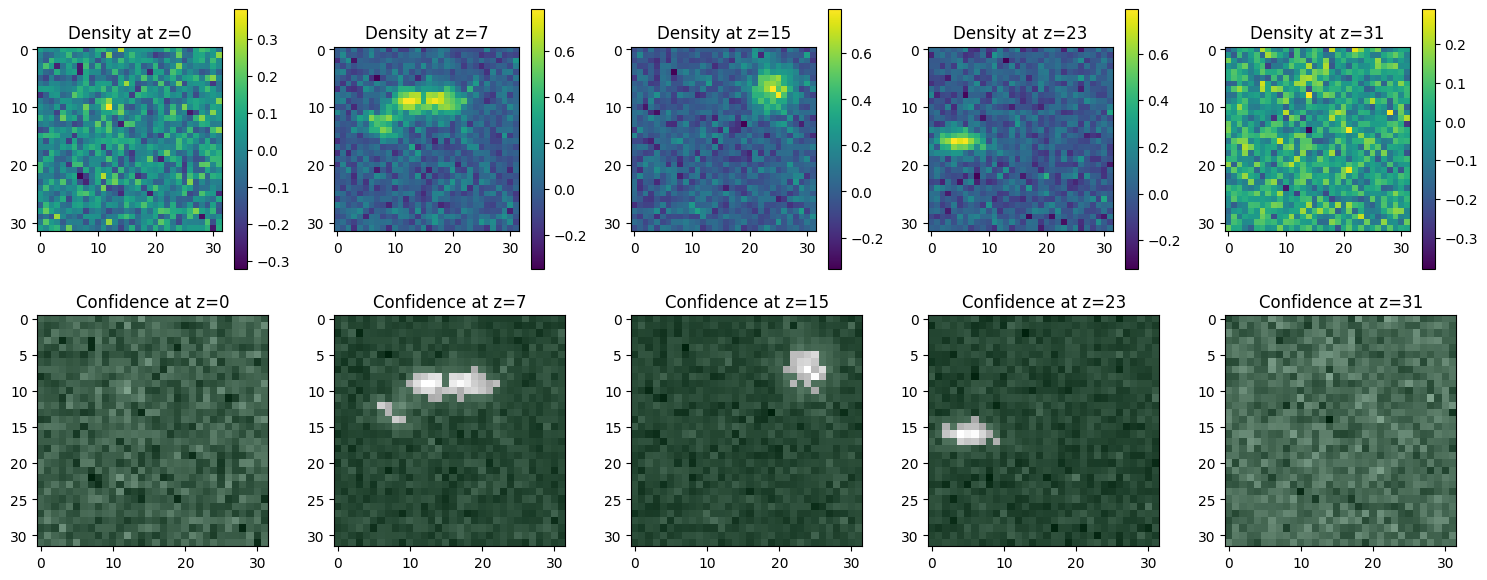


Visualizing along Y-axis:


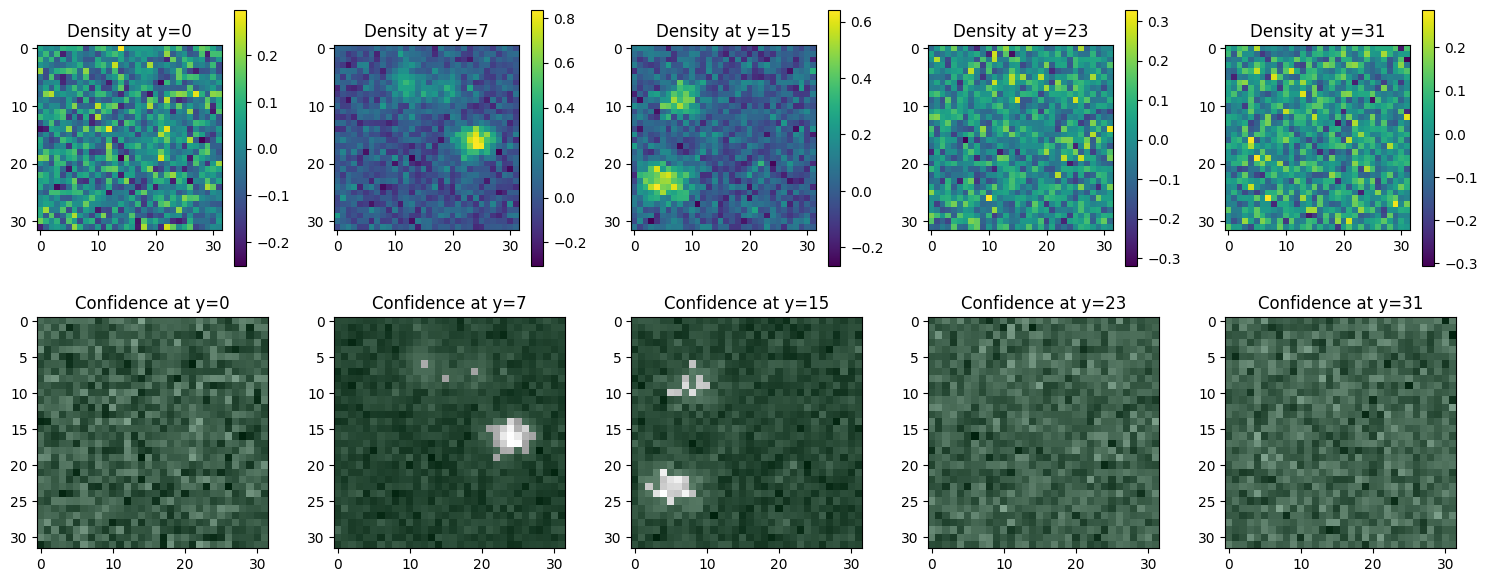


Visualizing along X-axis:


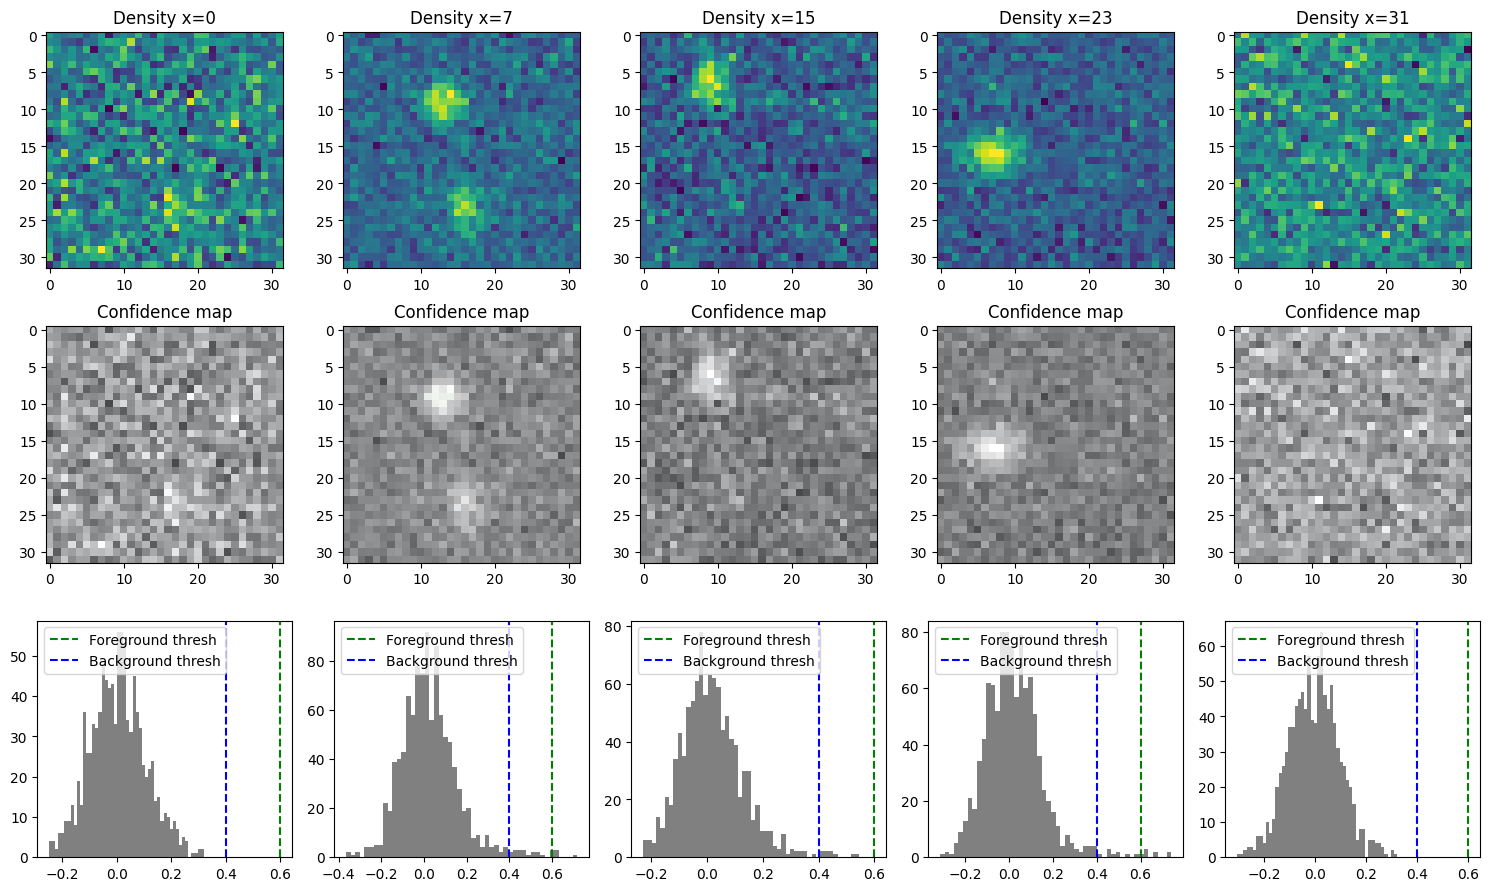

Visualizing 3D Structures...



3D Confidence Visualization:


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
  # Assuming your code is in pseudo_labeler.py
import plotly.graph_objects as go

def plot_3d_volume(volume, title="3D Density", threshold=0.2, colorscale='viridis'):
    """Interactive 3D visualization of a volume using Plotly."""
    x, y, z = np.mgrid[:volume.shape[0], :volume.shape[1], :volume.shape[2]]
    fig = go.Figure(data=go.Isosurface(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=volume.flatten(),
        isomin=threshold,
        isomax=volume.max(),
        surface_count=3,  # Number of isosurfaces
        colorscale=colorscale,
        opacity=0.6,
        caps=dict(x_show=False, y_show=False, z_show=False),
    ))
    fig.update_layout(title=title, scene=dict(aspectmode="cube"))
    fig.show()
def visualize_3d_confidence(pseudo_labels: torch.Tensor, 
                          label_mask: torch.Tensor,
                          threshold: float = 0.2):
    """3D visualization showing confident regions in green"""
    # Convert to numpy
    pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
    mask_np = label_mask.squeeze().detach().cpu().numpy()
    
    # Create coordinates
    x, y, z = np.mgrid[:pseudo_np.shape[0], 
                      :pseudo_np.shape[1], 
                      :pseudo_np.shape[2]]
    
    # Create figure with two isosurfaces
    fig = go.Figure()
    
    # 1. Add the density isosurface (semi-transparent)
    fig.add_trace(go.Isosurface(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=pseudo_np.flatten(),
        isomin=threshold,
        isomax=pseudo_np.max(),
        opacity=0.3,
        colorscale='gray',
        surface_count=2,
        name='Density'
    ))
    
    # 2. Add confidence mask (green)
    fig.add_trace(go.Isosurface(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=mask_np.flatten(),
        isomin=0.5,  # Mask threshold
        isomax=1,
        opacity=0.7,
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'green']],
        surface_count=1,
        name='Confident Regions'
    ))
    
    fig.update_layout(
        title='3D Confidence Visualization',
        scene=dict(
            aspectmode='cube',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(t=40, b=0, l=0, r=0)
    )
    fig.show()
def visualize_3d_detailed(pseudo_labels, label_mask, confidence_threshold):
    pseudo_np = pseudo_labels.squeeze().detach().cpu().numpy()
    mask_np = label_mask.squeeze().detach().cpu().numpy()
    background_mask = (pseudo_np <= (1 - confidence_threshold))
    
    x, y, z = np.mgrid[:pseudo_np.shape[0], :pseudo_np.shape[1], :pseudo_np.shape[2]]
    
    fig = go.Figure()
    
    # Particles (green)
    fig.add_trace(go.Isosurface(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=mask_np.flatten(),
        isomin=0.5,
        opacity=0.8,
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'green']],
        name='Particles'
    ))
    
    # Background (blue)
    fig.add_trace(go.Isosurface(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=background_mask.astype(float).flatten(),
        isomin=0.5,
        opacity=0.3,
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'blue']],
        name='Background'
    ))
    
    fig.update_layout(title='3D Particle/Background Confidence')
    fig.show()
# Add this to your test_pseudo_labeler() function:
def test_pseudo_labeler():
    # ... (previous code)
    
    # After 2D visualizations:
    print("\n3D Confidence Visualization:")
    visualize_3d_confidence(pseudo_labels, label_mask)
    
    return test_density, pseudo_labels, label_mask
# 1. Create a synthetic 3D density map with some Gaussian blobs
def create_test_density(size=(32, 32, 32)):
    """Create a test 3D density map with random Gaussian blobs"""
    density = np.zeros(size)
    coords = np.indices(size)
    
    # Add several Gaussian blobs
    for _ in range(5):
        A = np.random.uniform(0.5, 1.0)  # Amplitude
        x0, y0, z0 = np.random.randint(5, size[0]-5, size=3)  # Centers
        sx, sy, sz = np.random.uniform(1.5, 3.0, size=3)  # Widths
        
        # Add Gaussian to the density map - FIXED THE PARENTHESIS HERE
        density += A * np.exp(-(((coords[0]-z0)**2/(2*sz**2)) + 
                  ((coords[1]-y0)**2/(2*sy**2)) + 
                  ((coords[2]-x0)**2/(2*sx**2))))
    
    # Add some noise
    density += np.random.normal(0, 0.1, size=size)
    return torch.from_numpy(density).float()

# 2. Create a simple teacher model that just adds slight modifications
class SimpleTeacher(torch.nn.Module):
    def forward(self, x):
        return x
# 3. Test the pseudo-labeler
def test_pseudo_labeler():
    # Create test data
    test_density = create_test_density()
    
    # Create teacher model
    teacher = IdentityTeacher()
    
    pseudo_labeler = GaussianPseudoLabeler(
    confidence_threshold=0.6,
    threshold_from_both_sides=True,
    patch_size=9,
    peak_threshold_abs=0.1,
    min_amp=0.1
    )
    
        
    """# Initialize pseudo-labeler with more sensitive parameters
    pseudo_labeler = GaussianPseudoLabeler(
        confidence_threshold=0.6,       # More sensitive to faint particles
        patch_size=7,                   # For σ~2-3 voxels
        peak_threshold_abs=0.15,        # Catch weaker peaks
        peak_min_distance=2,            # For ~10nm particles at your resolution
        min_density_inside=0.25,        # Slightly more permissive
        min_amp=0.2                     # Allow smaller amplitudes
    )"""

    #pseudo_labeler = DefaultPseudoLabeler_original(threshold_from_both_sides=True,confidence_threshold=0.8)
    # Generate pseudo-labels and mask
    pseudo_labels, label_mask = pseudo_labeler(teacher, test_density)
    
    # Visualize results along different axes
    print("Visualizing along Z-axis:")
    pseudo_labeler.visualize_masked_density(pseudo_labels, label_mask, axis='z', n_slices=5)
    
    print("\nVisualizing along Y-axis:")
    pseudo_labeler.visualize_masked_density(pseudo_labels, label_mask, axis='y', n_slices=5)
    
    print("\nVisualizing along X-axis:")
    pseudo_labeler.visualize_masked_density_separate(pseudo_labels, label_mask, axis='x', n_slices=5)
    # Convert tensors to numpy for visualization
    test_density_np = test_density.squeeze().numpy()
    pseudo_labels_np = pseudo_labels.squeeze().detach().cpu().numpy()
    label_mask_np = label_mask.squeeze().detach().cpu().numpy()

    # Plot 3D structures
    print("Visualizing 3D Structures...")
    plot_3d_volume(test_density_np, "Input Density (3D)")
    plot_3d_volume(pseudo_labels_np, "Pseudo-Labels (3D)")
    plot_3d_volume(label_mask_np, "Confidence Mask (3D)", colorscale='greens')
    print("\n3D Confidence Visualization:")
    visualize_3d_confidence(pseudo_labels, label_mask)
    # Return the results for further inspection
    return test_density, pseudo_labels, label_mask

# Run the test
if __name__ == "__main__":
    test_density, pseudo_labels, label_mask = test_pseudo_labeler()

In [ ]:

# Add this to your test_pseudo_labeler() function:
def test_pseudo_labeler():
    # ... (previous code)
    
    # Convert tensors to numpy for visualization
    test_density_np = test_density.squeeze().numpy()
    pseudo_labels_np = pseudo_labels.squeeze().detach().cpu().numpy()
    label_mask_np = label_mask.squeeze().detach().cpu().numpy()

    # Plot 3D structures
    print("Visualizing 3D Structures...")
    plot_3d_volume(test_density_np, "Input Density (3D)")
    plot_3d_volume(pseudo_labels_np, "Pseudo-Labels (3D)")
    plot_3d_volume(label_mask_np, "Confidence Mask (3D)", colorscale='greens')

    return test_density, pseudo_labels, label_mask

In [ ]:
class DefaultPseudoLabeler:
    """Compute pseudo labels based on model predictions, typically from a teacher model.

    Args:
        activation: Activation function applied to the teacher prediction.
        confidence_threshold: Threshold for computing a mask for filtering the pseudo labels.
            If None is given no mask will be computed.
        threshold_from_both_sides: Whether to include both values bigger than the threshold
            and smaller than 1 - the thrhesold, or only values bigger than the threshold, in the mask.
            The former should be used for binary labels, the latter for for multiclass labels.
    """
    def __init__(
        self,
        activation: Optional[torch.nn.Module] = None,
        confidence_threshold: Optional[float] = None,
        threshold_from_both_sides: bool = True,
    ):
        self.activation = activation
        self.confidence_threshold = confidence_threshold
        self.threshold_from_both_sides = threshold_from_both_sides
        # TODO serialize the class names and kwargs for activation instead
        self.init_kwargs = {
            "activation": None, "confidence_threshold": confidence_threshold,
            "threshold_from_both_sides": threshold_from_both_sides
        }

    def _compute_label_mask_both_sides(self, pseudo_labels):
        upper_threshold = self.confidence_threshold
        lower_threshold = 1.0 - self.confidence_threshold
        mask = ((pseudo_labels >= upper_threshold) + (pseudo_labels <= lower_threshold)).to(dtype=torch.float32)
        return mask

    def _compute_label_mask_one_side(self, pseudo_labels):
        mask = (pseudo_labels >= self.confidence_threshold)
        return mask

    def __call__(self, teacher: torch.nn.Module, input_: torch.Tensor) -> torch.Tensor:
        """Compute pseudo-labels.

        Args:
            teacher: The teacher model.
            input_: The input for this batch.

        Returns:
            The pseudo-labels.
        """
        pseudo_labels = teacher(input_)
        if self.activation is not None:
            pseudo_labels = self.activation(pseudo_labels)
        if self.confidence_threshold is None:
            label_mask = None
        else:
            label_mask = self._compute_label_mask_both_sides(pseudo_labels) if self.threshold_from_both_sides\
                else self._compute_label_mask_one_side(pseudo_labels)
        return pseudo_labels, label_mask

    def step(self, metric, epoch):
        pass


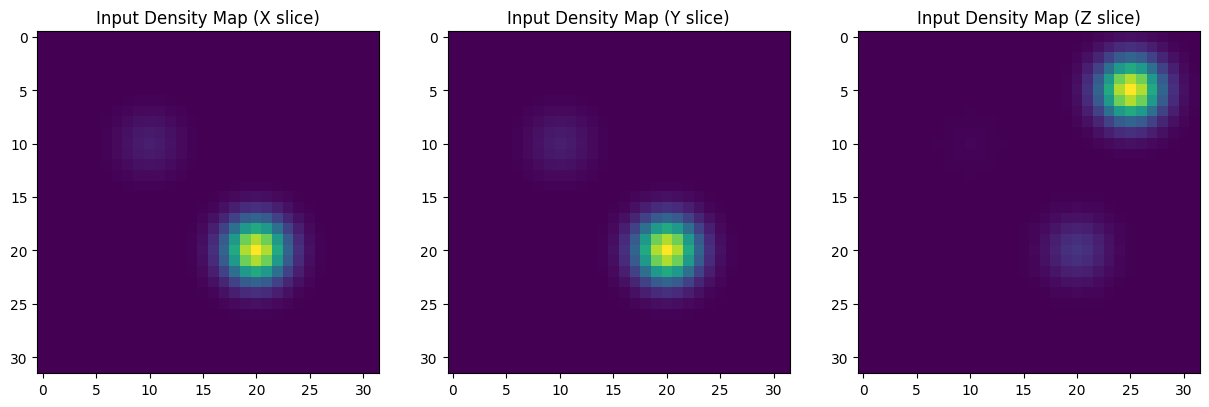

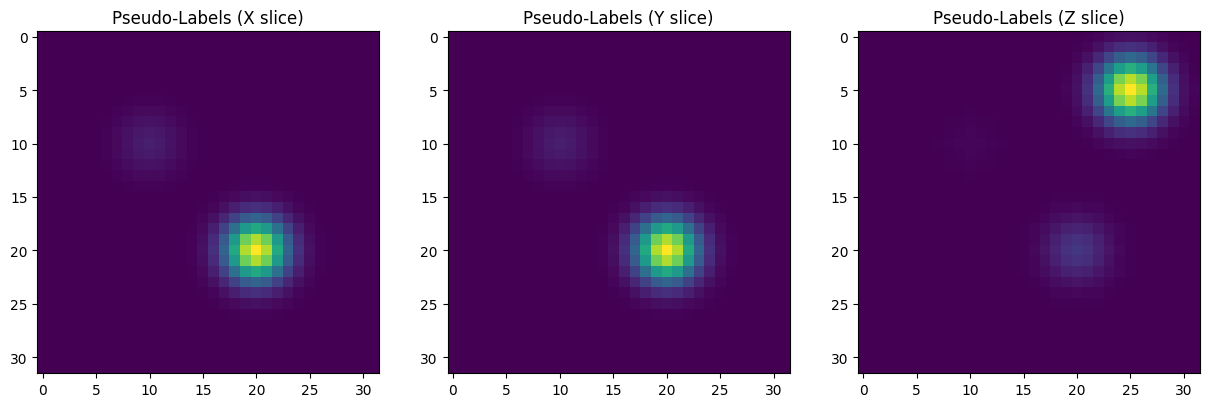

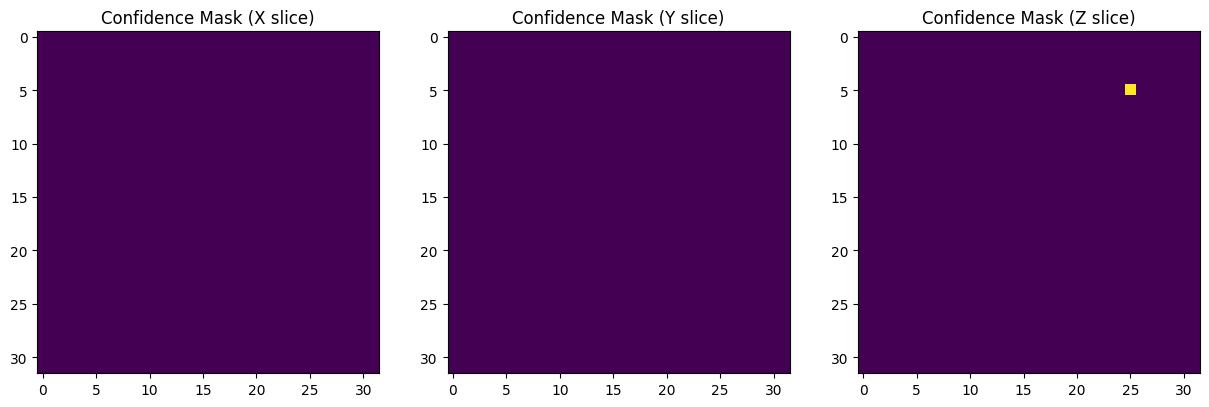

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Generate synthetic 3D Gaussian blobs
def generate_3d_gaussian_blob(shape, center, sigma=1.0, amplitude=1.0):
    x = torch.arange(shape[0]).float()
    y = torch.arange(shape[1]).float()
    z = torch.arange(shape[2]).float()
    x, y, z = torch.meshgrid(x, y, z, indexing='ij')
    gaussian = amplitude * torch.exp(
        -((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2) / (2 * sigma**2)
    )
    return gaussian

def generate_multiple_blobs(shape, centers, sigma=1.0, amplitude=1.0):
    volume = torch.zeros(shape)
    for center in centers:
        blob = generate_3d_gaussian_blob(shape, center, sigma, amplitude)
        volume += blob
    return volume

shape = (32, 32, 32)
centers = [(10, 10, 10), (20, 20, 20), (5, 25, 15)]
density_map = generate_multiple_blobs(shape, centers, sigma=2.0, amplitude=1.0)
density_map = density_map.unsqueeze(0).unsqueeze(0)  # (1, 1, 32, 32, 32)

# Mock teacher model
class MockTeacher(torch.nn.Module):
    def forward(self, x):
        return x  # Identity function (or add noise)

teacher = MockTeacher()

# Apply DefaultPseudoLabeler
pseudo_labeler = DefaultPseudoLabeler(
    activation=torch.nn.Sigmoid(),
    confidence_threshold=0.7,
    threshold_from_both_sides=True,
)

pseudo_labels, label_mask = pseudo_labeler(teacher, density_map)

# Squeeze for visualization
density_map = density_map.squeeze().numpy()
pseudo_labels = pseudo_labels.squeeze().numpy()
label_mask = label_mask.squeeze().numpy() if label_mask is not None else None

# Plot 2D slices
def plot_slices(volume, title="Volume"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(volume[volume.shape[0] // 2, :, :], cmap='viridis')
    axes[0].set_title(f"{title} (X slice)")
    axes[1].imshow(volume[:, volume.shape[1] // 2, :], cmap='viridis')
    axes[1].set_title(f"{title} (Y slice)")
    axes[2].imshow(volume[:, :, volume.shape[2] // 2], cmap='viridis')
    axes[2].set_title(f"{title} (Z slice)")
    plt.show()

plot_slices(density_map, "Input Density Map")
plot_slices(pseudo_labels, "Pseudo-Labels")
if label_mask is not None:
    plot_slices(label_mask, "Confidence Mask")

# Optional: 3D interactive plot
def plot_3d_isosurface(volume, threshold=0.5, title="3D Density"):
    x, y, z = np.mgrid[:volume.shape[0], :volume.shape[1], :volume.shape[2]]
    fig = go.Figure(data=go.Isosurface(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=volume.flatten(),
        isomin=threshold,
        isomax=volume.max(),
        caps=dict(x_show=False, y_show=False, z_show=False),
    ))
    fig.update_layout(title=title)
    fig.show()

plot_3d_isosurface(density_map, title="Input Density Map")
plot_3d_isosurface(pseudo_labels, title="Pseudo-Labels")
if label_mask is not None:
    plot_3d_isosurface(label_mask, title="Confidence Mask")